# Decision Trees (Regressor & Classifier) and Ensemble Methods (AdaBoost)

In [1]:
import graphviz
#from sklearn.tree import export_graphviz
#from IPython.display import Image

In [2]:
import numpy as np
import pandas as pd
from pylab import plt
from enum import Enum 
plt.style.use('seaborn')
%matplotlib inline
from pandas_datareader import data as web

# 1. Feature Extraction and Pre Processing

### 1.1 Utility methods and classes for feature extraction

 Feature class containing  possible features which are supported

In [3]:
class Feature(Enum):
    OHLC           = 1
    LAGGED_RETURNS = 2
    SMA_PRICE      = 3
    SMA_VAR        = 4
    RSI            = 5
    MACD           = 6
    EWMA_PRICE     = 7
    EWMA_VAR       = 8
    VAR            = 9

### 1.2 Gaussian method
Gaussian method to normalize and transform the data to zero mean

In [4]:
def gaussian(xa):
    x = xa.copy()
    mean = x.mean()
    std = x.std()
    return (x - mean) / std, mean, std

## 1.3 RSI Feature

In [5]:
def RSI(series, period, normalize = True):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 #pd.stats.moments.ewma(d, com=period-1, adjust=False)

 rs = u.ewm(span=period-1, adjust=False).mean() / d.ewm(span=period-1, adjust=False).mean()

 rsi = 100 - 100 / (1 + rs)
 
 if normalize:
  rsi, mean, std  = gaussian(rsi)
    
 return rsi

### 1.4 MACD Feature

In [6]:
def MACD(series, period, normalize = True):
 exp1 = series.ewm(span=12, adjust=False).mean()
 exp2 = series.ewm(span=26, adjust=False).mean()
 macd = exp1-exp2
 
 if normalize:
  macd, mean, std = gaussian(macd)

 return macd

### 1.5 get_data: An utility method that encapsulates historical price  download and the feature extraction 
<b>Input Arguments:</b><br>
features = This is a list of values from Feature type class, it contains the type of features to be extracted.<br>
normalize = A Boolean variable specifying if the feature values to be normalized (zero mean)

<b>Return Values:</b> <br>
Returns the features

In [7]:
def get_data(features, normalize = True):
    # Download the histo market data
    # Extract the Features
    # Returns Featurs and columns
    data = pd.DataFrame(web.DataReader('AMZN', data_source='yahoo')[['High', 'Low', 'Open', 'Close']])
    data.columns = ['h', 'l', 'o', 'c']
    cols = []
    
    # The log return
    data['returns'] = np.log(data['c'] / data['c'].shift(1))
    # Return Sign
    data['d'] = np.where(data['returns'] > 0, 1, -1)
    
    LAGS = 5
    if Feature.OHLC in features:
        data['h-l'] = data['h'] - data['l']
        data['c-o'] = data['c'] - data['o']
        cols.append('c-o')
        cols.append('h-l')
    if Feature.LAGGED_RETURNS in features:
        for lag in range(1, LAGS+1):
            col = 'ret_%d' % lag
            data[col] = data['returns'].shift(lag)
            cols.append(col)
    if Feature.SMA_PRICE in features: 
        data['sma10'] = data['c'].rolling(10).mean() # Simple moving average
        data['sma25'] = data['c'].rolling(25).mean()
        cols.append('sma10')
        cols.append('sma25')
    if Feature.SMA_VAR in features: 
        data['var10'] = data['c'].rolling(10).std() # Simple moving average
        data['var25'] = data['c'].rolling(25).std()
        cols.append('var10')
        cols.append('var25')
    if Feature.RSI in features: 
        data['rsi'] = RSI(data['c'], 10, False)
        cols.append('rsi')
    if Feature.MACD in features: 
        data['macd'] = MACD(data['c'], 10, False)
        cols.append('macd')
    if Feature.EWMA_PRICE in features: 
        data['ewma'] = data['c'].ewm(span=20, adjust=False).mean()
        cols.append('ewma')
    if Feature.EWMA_VAR in features: 
        data['ewmstd'] = data['c'].ewm(span=20, adjust=False).std()
        cols.append('ewmstd')
    
  
    data.dropna(inplace=True)
    #print(data.head())
    # Get the gaussian of all the values - so that we have normalized the data.
    if normalize:
       for col in cols:
           data[col], mean, std = gaussian(data[col])
        
    return data, cols

In [8]:
data, cols = get_data(
    [Feature.OHLC,  
     Feature.LAGGED_RETURNS,  
     Feature.SMA_PRICE,  
     Feature.SMA_VAR,  
     Feature.RSI,  
     Feature.MACD, 
     Feature.EWMA_PRICE,  
     Feature.EWMA_VAR])

In [9]:
cols

['c-o',
 'h-l',
 'ret_1',
 'ret_2',
 'ret_3',
 'ret_4',
 'ret_5',
 'sma10',
 'sma25',
 'var10',
 'var25',
 'rsi',
 'macd',
 'ewma',
 'ewmstd']

# 2. Decision Tree Regressor

In [10]:
from sklearn.tree import DecisionTreeRegressor

In [11]:
regr = DecisionTreeRegressor(max_depth=4)
regr.fit(data[cols], data['d'])
regr.score(data[cols], data['d'])

0.5999648702887402

# 3. AdaBoostRegressor

Boosting is an ensemble technique that attempts TO CREATE A STRONG CLASSIFIER FROM A NUMBER
OF WEEK CLASSIFIERS. <br><br>
1) First, a model is fitted from the training data, <br> 
2) then the second model created that attempts to correct the errors from the first model.<br> 
<br> 
AdaBoost was the first successful boosting algorithm developed for binary classification.

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [13]:
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_1.fit(data[cols], data['d'])
regr_1.score(data[cols], data['d'])

0.5999648702887401

In [14]:
rng = np.random.RandomState(1)
regr_3 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=300, random_state=rng)
regr_3.fit(data[cols], data['d'])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=<mtrand.RandomState object at 0x00000258B1267090>)

In [15]:
regr_3.score(data[cols], data['d'])

0.9996203846046032

In [16]:
import os
os.environ["PATH"] = r'C:\Users\deepa\Anaconda2\envs\ana5py36\Library\bin' + os.pathsep + os.environ["PATH"]
os.environ["PATH"] = r'C:\Users\deepa\Anaconda2\external_library\release\bin' + os.pathsep + os.environ["PATH"]  


<b>Summary:</b> Scores on DecisionTree and AdaBoost models <br>
    DecisionTreeRegressor score 72% <br>
    AdaBoostRegressor score 95% <br> 


In [17]:
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

In [18]:
# Visualising Decision Tree with graphviz
dot_data = export_graphviz(regr_1, out_file=None, feature_names= cols, class_names=['Down', 'Up'], filled=True, rounded=True, proportion=True)
graph = graphviz.Source(dot_data, filename='.\\TreeImageREG_graphviz2', format='jpeg')
graph.render();

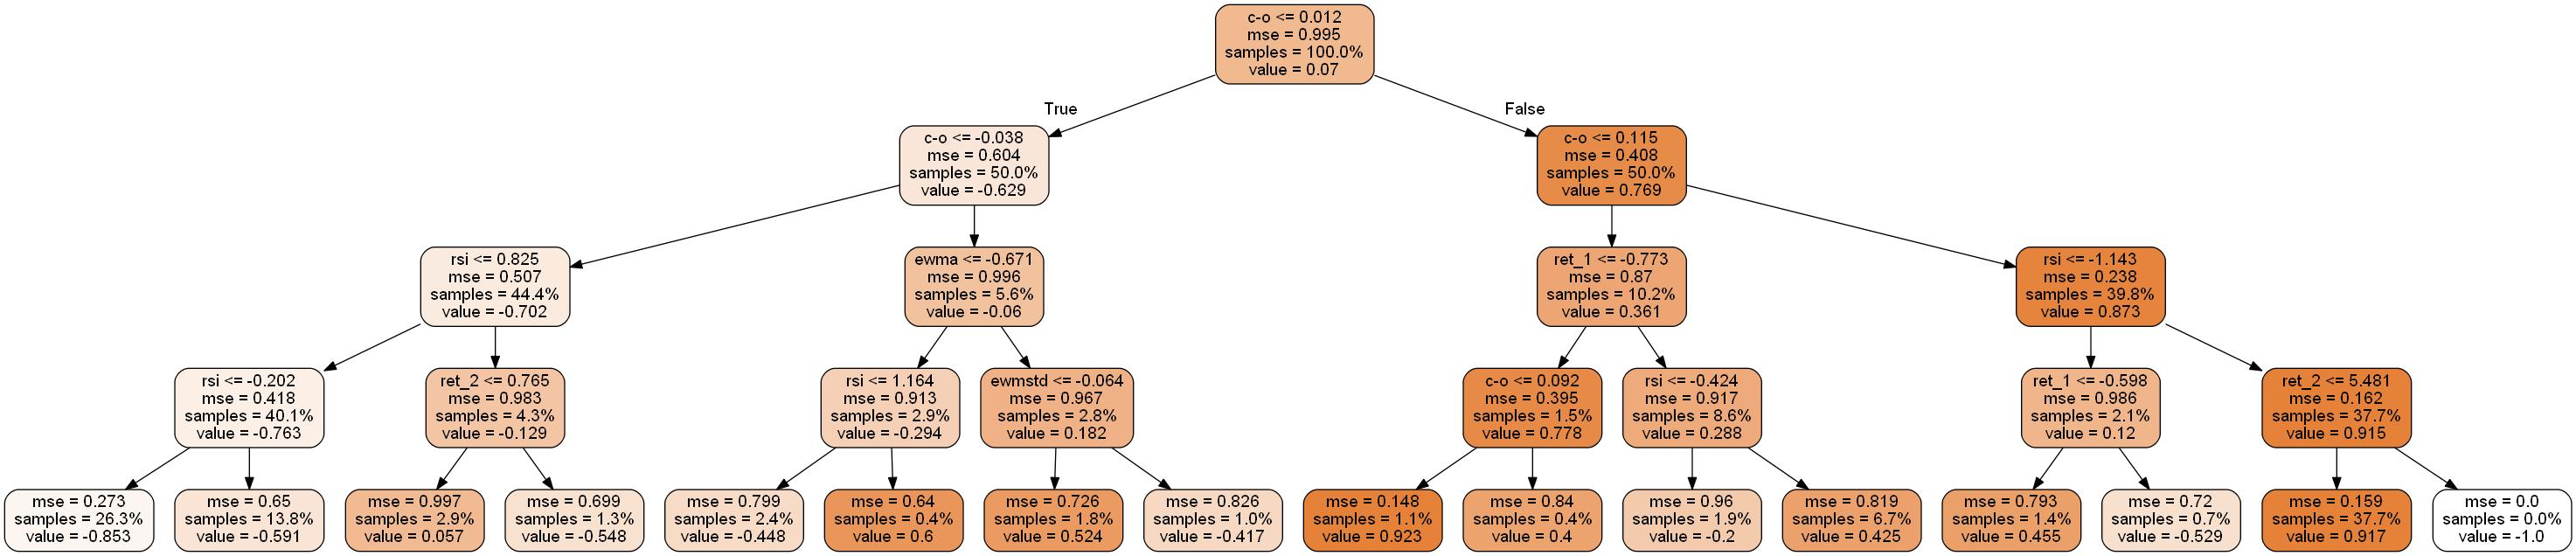

In [19]:
Image('.\\TreeImageREG_graphviz2.jpeg')

Decision Tree Classifier operate with very elaborate decision tree -- and will predict data points on which it
was trained EXACTLY.<br>
The open question remains if the fitted decision tree will be as effective on OUT OF SAMPLE data. Perhaps
yes if the data has same story.

# 4. Train Test Split and Validation of AdaBoostRegressor

The data we use is usually split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s prediction on this subset.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
from sklearn import model_selection
train, test = model_selection.train_test_split(data, test_size=0.5, shuffle=True)

## AdaBoostRegressor

Boosting is an ensemble technique that attempts TO CREATE A STRONG CLASSIFIER FROM A NUMBER
OF WEEK CLASSIFIERS. <br><br>
1) First, a model is fitted from the training data, <br> 
2) then the second model created that attempts to correct the errors from the first model.<br> 
<br> 
AdaBoost was the first successful boosting algorithm developed for binary classification.

In [22]:
rng = np.random.RandomState(1)
regr_3 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, random_state=rng)
regr_3.fit(train[cols], train['d'])

print("AdaBoostRegressor Score on Train Set={}".format(regr_3.score(train[cols], train['d'])))
print("AdaBoostRegressor Score on Test  Set={}".format(regr_3.score(test[cols], test['d'])))


AdaBoostRegressor Score on Train Set=0.9981878395928371
AdaBoostRegressor Score on Test  Set=0.5709020829638851


The AdaBoostRegressor model has performed very well on the Training Set and has as score of 99% whereas on the test set the results are 60%

# 5. Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
regrC = DecisionTreeClassifier(max_depth=4)
regrC.fit(data[cols], data['d'])
regrC.score(data[cols], data['d'])

0.8711036225779275

In [25]:
data['p'] = regrC.predict(data[cols])
#data['p'].value_counts()

In [26]:
data['p'] = np.where(data['p'] > 0, 1, -1)

In [27]:
data['s'] = data['p'] * data['returns']

In [28]:
data[['returns', 's']].sum().apply(np.exp)

returns    1.734518e+01
s          3.938138e+12
dtype: float64

In [29]:
data[['returns', 's']].sum().apply(np.exp)

returns    1.734518e+01
s          3.938138e+12
dtype: float64

In [30]:
print('Training accuracy:', regrC.score(data[cols], data['d']))

Training accuracy: 0.8711036225779275


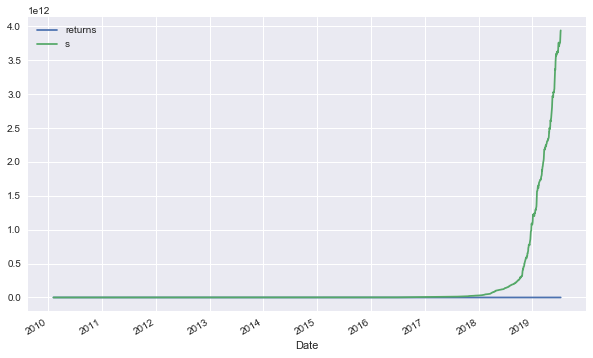

In [31]:
data[['returns', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# 6. AdaBoost Classifier

In [32]:
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [33]:
rng = np.random.RandomState(1)
regrAdaBoost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=300, random_state=rng)
regrAdaBoost.fit(data[cols], data['d'])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=<mtrand.RandomState object at 0x00000258B132C948>)

In [34]:
regrAdaBoost.score(data[cols], data['d'])

0.9996203846046032

In [35]:
data['pab'] = regrAdaBoost.predict(data[cols])

In [36]:
data['pab'] = np.where(data['pab'] > 0, 1, -1)

In [37]:
data['sab'] = data['pab'] * data['returns']

In [38]:
data[['returns', 'sab']].sum().apply(np.exp)

returns    1.734518e+01
sab        1.073601e+14
dtype: float64

In [39]:
data[['returns', 'sab']].sum().apply(np.exp)

returns    1.734518e+01
sab        1.073601e+14
dtype: float64

In [40]:
print('Training accuracy:', regrAdaBoost.score(data[cols], data['d']))

Training accuracy: 0.9996203846046032


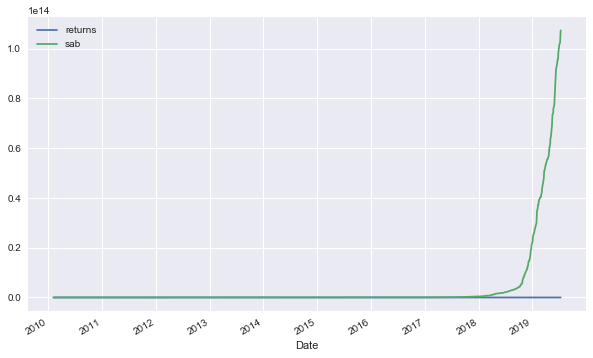

In [41]:
data[['returns', 'sab']].cumsum().apply(np.exp).plot(figsize=(10, 6));